#Install Dependencies#

In [ ]:
# These are used for env.render problem 
!apt update
!apt install -y xvfb
!pip install -U pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpa

In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

# Utility#

In [ ]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

#Baseline#

In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn
import gym
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque # https://docs.python.org/2/library/collections.html

%matplotlib inline

In [ ]:
# Environment configuration
mpl.rc('animation', html='jshtml') # for animation setup
replay_memory = deque(maxlen=2000) # list-like, it is used for save the status, action,...etc.
replay_memory

deque([])

In [ ]:
# List all the game that gym has.
print('Game list:',gym.envs.registry.all())

# Specifiy the game that we want to play
game ='Pong-v0'
env = gym.make(game)
print('Selected Game:', game)

# Show how many actions in this game
print('Total actions:', env.action_space.n)

# Show what actions this game has
print('Action Description:',env.unwrapped.get_action_meanings())

# Show the dimension of observation in this game. 
# We can find out the dimension in Pong-v0 is 210x160x3 (image height, image width, image channel)
print('observation space:',env.observation_space)

# Specify the random seed. Let the game start at the same state every time
env.seed(41)

# Observe the starting state
obs = env.reset()
obs.shape

Game list: dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer

(210, 160, 3)

Reward: 0.0
Gameover: False
Info: {'ale.lives': 0}


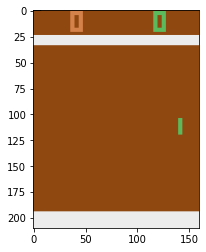

In [ ]:
# Example of manually playing the game
action = 3 # ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
obs, reward, done, info = env.step(action) # env.step is used for updating the status by new action
img = env.render(mode="rgb_array")
plt.imshow(img)

print('Reward:', reward)
print('Gameover:', done)
print('Info:',info)

# When game is over, restart the game
if done == True:
    obs = env.reset()

In [ ]:
# Example of animation, the agent takes random actions here.
frames = []
obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = random.randint(0,5)
    obs, reward, done, info = env.step(action)
    if done:
        break

plot_animation(frames)

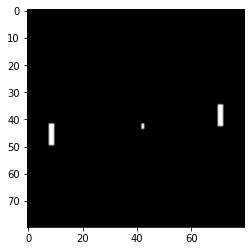

In [ ]:
def prepro(I):
 """
  prepro 210x160x3 frame into 6400 (80x80) 1D float vector 
 """
 I = I[35:195] # crop
 I = I[::2,::2,0] # downsample by factor of 2
 I[I == 144] = 0 # erase background (background type 1)
 I[I == 109] = 0 # erase background (background type 2)
 I[I != 0] = 1 # everything else (paddles, ball) just set to 1
 return I.astype(np.float).ravel()

#Show preprocessed
obs_preprocessed = prepro(obs).reshape(80,80)

plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [ ]:
def discount_rewards(r, gamma):
 """
 take 1D float array of rewards and compute discounted reward
 """
 r = np.array(r)
 discounted_r = np.zeros_like(r).astype(float) # Return an array of zeros with the same shape and type as a given array.
 running_add = 0
 for t in reversed(range(0, r.size)):
   if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset 
   running_add = running_add * gamma + r[t] 
   discounted_r[t] = running_add
 discounted_r -= np.mean(discounted_r) #normalizing the result
 discounted_r /= np.std(discounted_r) #idem using standar deviation
 return discounted_r


In [ ]:
from datetime import datetime
from keras import callbacks
import os

# initialize variables
resume = True
running_reward = None
epochs_before_saving = 10
log_dir = './log' + datetime.now().strftime("%Y%m%d-%H%M%S") + "/"

# load pre-trained model if exist
if (resume and os.path.isfile('my_model_weights.h5')):
    print("loading previous weights")
    model.load_weights('my_model_weights.h5')
    
# add a callback tensorboard object to visualize learning
tbCallBack = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,  
          write_graph=True, write_images=True)

In [ ]:
# import necessary modules from keras
import keras
from keras.layers import Dense,Reshape, Conv2D, Flatten
from keras.models import Sequential,InputLayer
from keras.optimizers import Adam

#The 80 * 80 input dimension comes from the pre-processing of the raw pixels made by Karpathy (the only important pixels are the balls and the paddle)
#Input here represents the difference in pixels betewen one frame and another, giving you direction of agents and ball. Encoded in Karpathy’s own preprocessing functions

model = Sequential()
model.add(Dense(units=200,input_dim=80*80, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal')) # 1 value to represent ACTION UP
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               1280200   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Hyperparameter
UP_ACTION = 2
DOWN_ACTION = 3
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0
history = []
observation = env.reset()
prev_input = None



# Load model 
model.load_weights('my_model_weights_700.h5')


while (True):

    # preprocess the observation, set input as difference between images
    cur_input = prepro(observation)
    
    if prev_input is not None:
      x = cur_input - prev_input
    else:
      x =  np.zeros(80 * 80)
    
    prev_input = cur_input
    
    # forward the policy network and sample action according to the proba distribution
    proba = model.predict(np.expand_dims(x, axis=1).T)
    if np.random.uniform() < proba:
      action = UP_ACTION
    else:
      action = DOWN_ACTION

    if action == 2:
      y = 1 # label y as 1 when action is UP
    else:
      y = 0 # label y as 0 when action is DOWN

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment
    observation, reward, done, info = env.step(action)
    rewards.append(reward)
    reward_sum += reward
    
    # end of an episode
    if done:
        print('At the end of episode', episode_nb, 'total step :', len(x_train),'the total reward was :', reward_sum)
        
        # increment episode number
        episode_nb += 1
        
        # training
        model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, callbacks=[tbCallBack], sample_weight=discount_rewards(rewards, gamma))
        
        # Saving the weights used by our model
        if episode_nb % epochs_before_saving == 0:    
            model.save_weights('my_model_weights' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5')
        
        # Reinitialization
        x_train, y_train, rewards = [],[],[]
        observation = env.reset()
        reward_sum = 0
        prev_input = None

    if episode_nb>=100:
      break

At the end of episode 0 total step : 2223 the total reward was : -18.0
70/70 [==============================] - 1s 8ms/step - loss: 0.0127 - accuracy: 0.9773
At the end of episode 1 total step : 2623 the total reward was : -18.0
82/82 [==============================] - 1s 7ms/step - loss: 0.0014 - accuracy: 0.9733
At the end of episode 2 total step : 2764 the total reward was : -16.0
87/87 [==============================] - 1s 6ms/step - loss: -0.0019 - accuracy: 0.9837
At the end of episode 3 total step : 1879 the total reward was : -19.0
59/59 [==============================] - 0s 8ms/step - loss: -0.0034 - accuracy: 0.9814
At the end of episode 4 total step : 3307 the total reward was : -12.0
104/104 [==============================] - 1s 6ms/step - loss: 0.0076 - accuracy: 0.9761
At the end of episode 5 total step : 3034 the total reward was : -12.0
95/95 [==============================] - 1s 6ms/step - loss: -0.0051 - accuracy: 0.9763
At the end of episode 6 total step : 2832 the t

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon: # Exploration
        return np.random.randint(2) + 2 # Only for action 2 and 3
    else:
        Q_values = model.predict(np.expand_dims(state, axis=1).T) # Exploitation, Q_value = [[0.557777]]
        if np.random.rand() < Q_values:
          action = 2 
        else:
          action = 3
        return action 

In [ ]:
env.seed(42)
observation = env.reset()

frames = []
prev_input = None
cur_input = prepro(observation)
while True:
  cur_input = prepro(obs)
  if prev_input is not None:
    x = cur_input - prev_input
  else:
      x =  np.zeros(80 * 80)    
  prev_input = cur_input
  action = epsilon_greedy_policy(x)
  obs, reward, done, info = env.step(action)

  img = env.render(mode="rgb_array")
  frames.append(img)
  if done:
    break
    
plot_animation(frames)